In [8]:
import warnings

import colorcet as cc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from desmin_reconstruction.analysis.ripley import (
    getis_franklin_L,
    getis_franklin_L_bivariate,
)
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from tqdm import tqdm


COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00", "actin": "#0000FF"}
LABEL_DICT = {"desmin": "Desmin", "actin": "Actin", "actinin": "α-actinin"}

df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
out = df.partition_by("probe")

In [2]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(59957, 3)

In [3]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [4]:
gf_histograms = []
bins = (np.linspace(0, 0.7, 25),) * 2

for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     transform_fn_sq, _ = align_patch(
    #         sq1,
    #         tilt_sweep_values=np.arange(-5, 5, 0.001),
    #         rotation_sweep_values=np.arange(-4, 4, 0.1),
    #         min_cluster_size=500,
    #         min_samples=10,
    #     )
    # sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    gf_desmin = getis_franklin_L(sq1["desmin"], 0.1385, [4.0, 4.0, 1.0])
    gf_desmin_cross = getis_franklin_L_bivariate(
        sq1["desmin"], sq1["actinin"], 0.1385, [4.0, 4.0, 1.0]
    )
    gf_histograms.append(np.histogram2d(gf_desmin, gf_desmin_cross, bins)[0])

100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


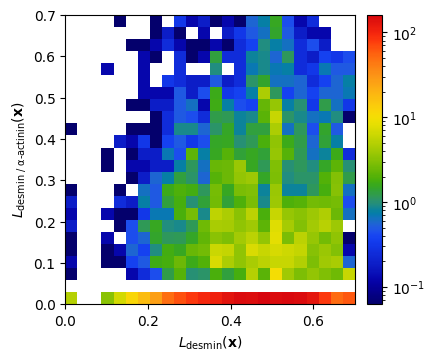

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), constrained_layout=True)
mesh = ax.pcolormesh(
    *bins, np.mean(gf_histograms, axis=0).T, cmap=cc.cm.rainbow4, norm=mcolors.LogNorm()
)
plt.axis("square")
ax.set_xlabel(r"$L_{\text{desmin}}(\mathbf{x})$")
ax.set_ylabel(r"$L_{\text{desmin / α-actinin}}(\mathbf{x})$")
fig.colorbar(
    mesh,
    ax=ax,
    pad=0.03,
)

In [7]:
df = pl.read_csv("../data/results/actin_desmin_600nm_filtered.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("actin", "desmin"))
}

100%|██████████| 25/25 [02:24<00:00,  5.78s/it]


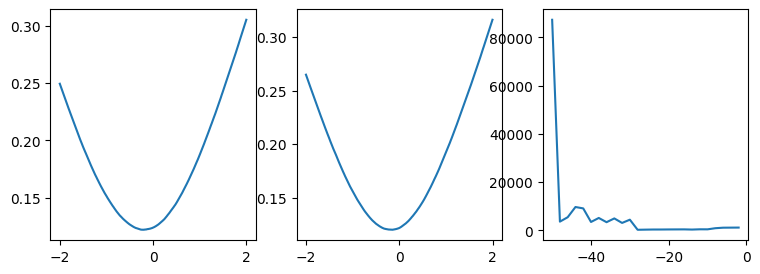

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-50, 0.0, 2.0),
        min_cluster_size=200,
        min_samples=1,
        clustering_species="actin",
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

points_final = {k: transform_fn(v) for k, v in points.items()}

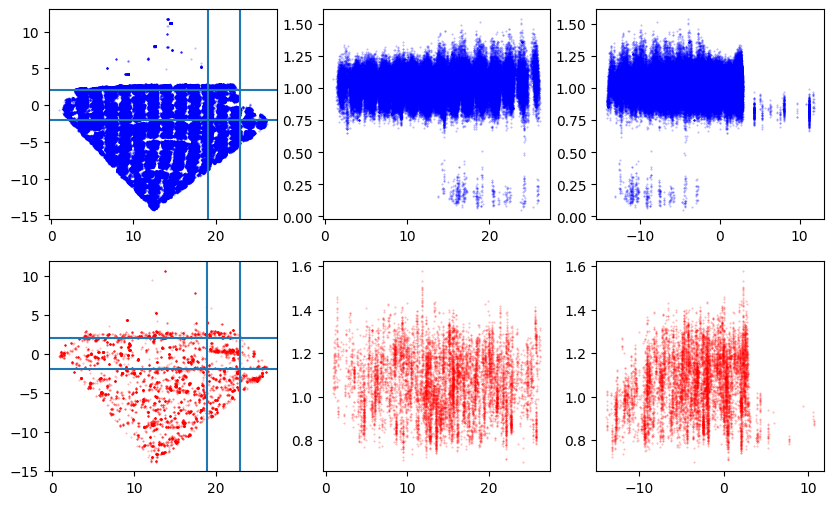

In [10]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("actin", "desmin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    x0 = 19.0
    y0 = -2
    ax.axhline(y=y0)
    ax.axhline(y=y0 + 4)
    ax.axvline(x=x0)
    ax.axvline(x=x0 + 4)


In [11]:
x0s = (3, 7, 7, 11, 11, 11, 15, 15, 15, 19)
y0s = (-2, -1.5, -5.5, -1, -5, -9, 0.5, -3.5, -7.5, -2)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [30]:
gf_histograms = []
bins = (np.linspace(0, 1.5, 25),) * 2

for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     transform_fn_sq, _ = align_patch(
    #         sq1,
    #         tilt_sweep_values=np.arange(-5, 5, 0.001),
    #         rotation_sweep_values=np.arange(-4, 4, 0.1),
    #         min_cluster_size=500,
    #         min_samples=10,
    #     )
    # sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    gf_desmin = getis_franklin_L(sq1["desmin"], 0.1385, [4.0, 4.0, 1.0])
    gf_desmin_cross = getis_franklin_L_bivariate(
        sq1["desmin"], sq1["actin"], 0.1385, [4.0, 4.0, 1.0]
    )
    gf_histograms.append(np.histogram2d(gf_desmin, gf_desmin_cross, bins)[0])

100%|██████████| 10/10 [00:00<00:00, 92.60it/s]


In [31]:
np.mean(gf_histograms, axis=0)

array([[1.7, 0.5, 0.7, 1.2, 0.5, 0.4, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.9, 0.7, 1.3, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.4, 0.3, 1.3, 0.9, 0.4, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [2.1, 1.5, 1.7, 3.2, 1.8, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 1.4, 2.9, 1.3, 0.9, 0.4, 0.3, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [3. , 1.5, 3.5, 4.2, 3.2, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1.8, 1.4, 4.8, 2.3, 1.3, 0.5, 0. 

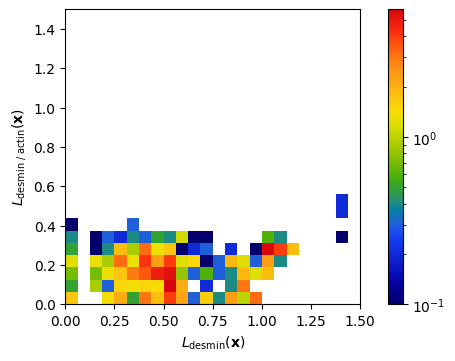

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), constrained_layout=True)
mesh = ax.pcolormesh(
    *bins, np.mean(gf_histograms, axis=0).T, cmap=cc.cm.rainbow4, norm=mcolors.LogNorm()
)
plt.axis("square")
ax.set_xlabel(r"$L_{\text{desmin}}(\mathbf{x})$")
ax.set_ylabel(r"$L_{\text{desmin / actin}}(\mathbf{x})$")
fig.colorbar(
    mesh,
    ax=ax,
    pad=0.03,
)